In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from folium import plugins


In [3]:
restaurant_csv_path = "data/DOHMH_New_York_City_Restaurant_Inspection_Results.csv"
df = pd.read_csv(restaurant_csv_path)
# Get a sense of what each column is:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332260 entries, 0 to 332259
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   CAMIS                  332260 non-null  int64  
 1   DBA                    330973 non-null  object 
 2   BORO                   332260 non-null  object 
 3   BUILDING               331671 non-null  object 
 4   STREET                 332248 non-null  object 
 5   ZIPCODE                327268 non-null  float64
 6   PHONE                  332233 non-null  object 
 7   CUISINE DESCRIPTION    328321 non-null  object 
 8   INSPECTION DATE        332260 non-null  object 
 9   ACTION                 328322 non-null  object 
 10  VIOLATION CODE         324577 non-null  object 
 11  VIOLATION DESCRIPTION  326583 non-null  object 
 12  CRITICAL FLAG          332260 non-null  object 
 13  SCORE                  316878 non-null  float64
 14  GRADE                  168065 non-nu

In [4]:
# Quick check of missing values:
df.isna().sum()

CAMIS                         0
DBA                        1287
BORO                          0
BUILDING                    589
STREET                       12
ZIPCODE                    4992
PHONE                        27
CUISINE DESCRIPTION        3939
INSPECTION DATE               0
ACTION                     3938
VIOLATION CODE             7683
VIOLATION DESCRIPTION      5677
CRITICAL FLAG                 0
SCORE                     15382
GRADE                    164195
GRADE DATE               168554
RECORD DATE                   0
INSPECTION TYPE            3938
Latitude                    316
Longitude                   316
Community Board            5790
Council District           5782
Census Tract               5782
BIN                        7289
BBL                         810
NTA                        5790
dtype: int64

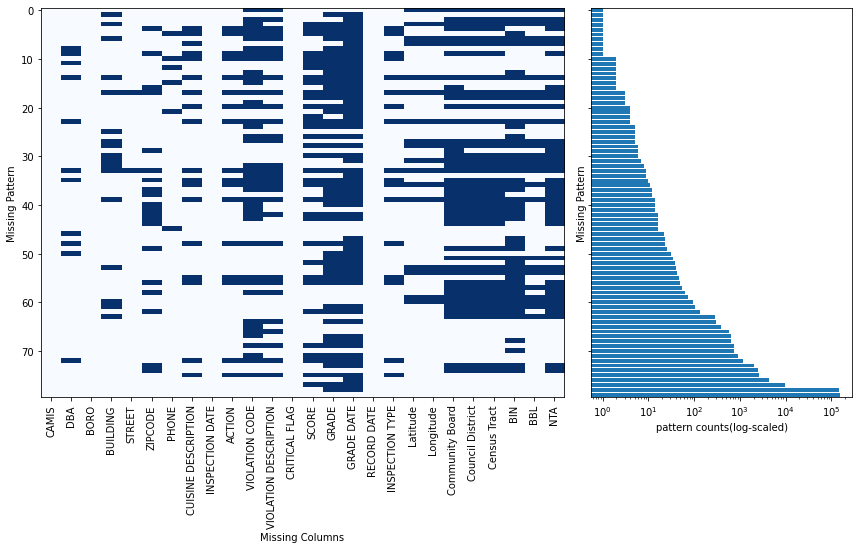

In [5]:
# missing value pattern
missing_patterns = df.isna().groupby(list(df.isna().columns),as_index=False).size()
missing_patterns = missing_patterns.sort_values(by='size').reset_index(drop=True)
fig, ax = plt.subplots(1,2, figsize=(12,6), gridspec_kw={'width_ratios': [2,1]}, sharey = True)
fig.tight_layout()

ax[0].imshow(missing_patterns.iloc[:,0:-1], aspect='auto', cmap = 'Blues')
ax[0].set_xlabel('Missing Columns')
ax[0].set_ylabel("Missing Pattern")
ax[0].set_xticks(ticks = np.arange(26), labels = missing_patterns.columns[0:-1], rotation = 90)


ax[1].barh(missing_patterns['size'].index, missing_patterns['size'])
ax[1].set_xscale('log')

# for i, v in enumerate(missing_patterns['size']):
#     ax[1].text(v + 3, i + .25, str(v), color='black')

ax[1].set_xlabel('pattern counts(log-scaled)')
ax[1].set_ylabel("Missing Pattern")
plt.show()

We need to drop any rows that have a missing grade, because this is the target we want to predict, so it makes sense to drop these rows.

May just make sense to drop all rows with missing values, since most of the feats are catgeorical, so it is hard to impute those

In [6]:
# df.dropna(subset=['GRADE'])
df = df.dropna()

Now, lets explore the distributions of the observed data points. Makes the most sense to first start with the target value's distribution

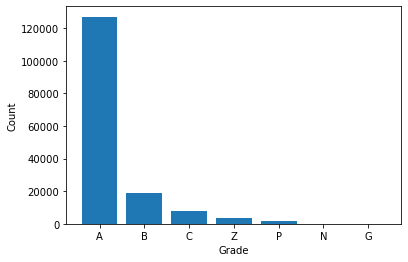

In [7]:
grades = pd.DataFrame(df["GRADE"].value_counts())
plt.bar(grades.index, height=grades["GRADE"])
plt.xlabel("Grade")
plt.ylabel("Count")
plt.show()

Note that: 	
Grade associated with the inspection; 

• N = Not Yet Graded

• A = Grade A

• B = Grade B

• C = Grade C

• Z = Grade Pending

• P= Grade Pending issued on re-opening following an initial inspection that resulted in a closure

Clearly, there is an ordinal ranking system to these, so it makes sense to encode them ordinally. 

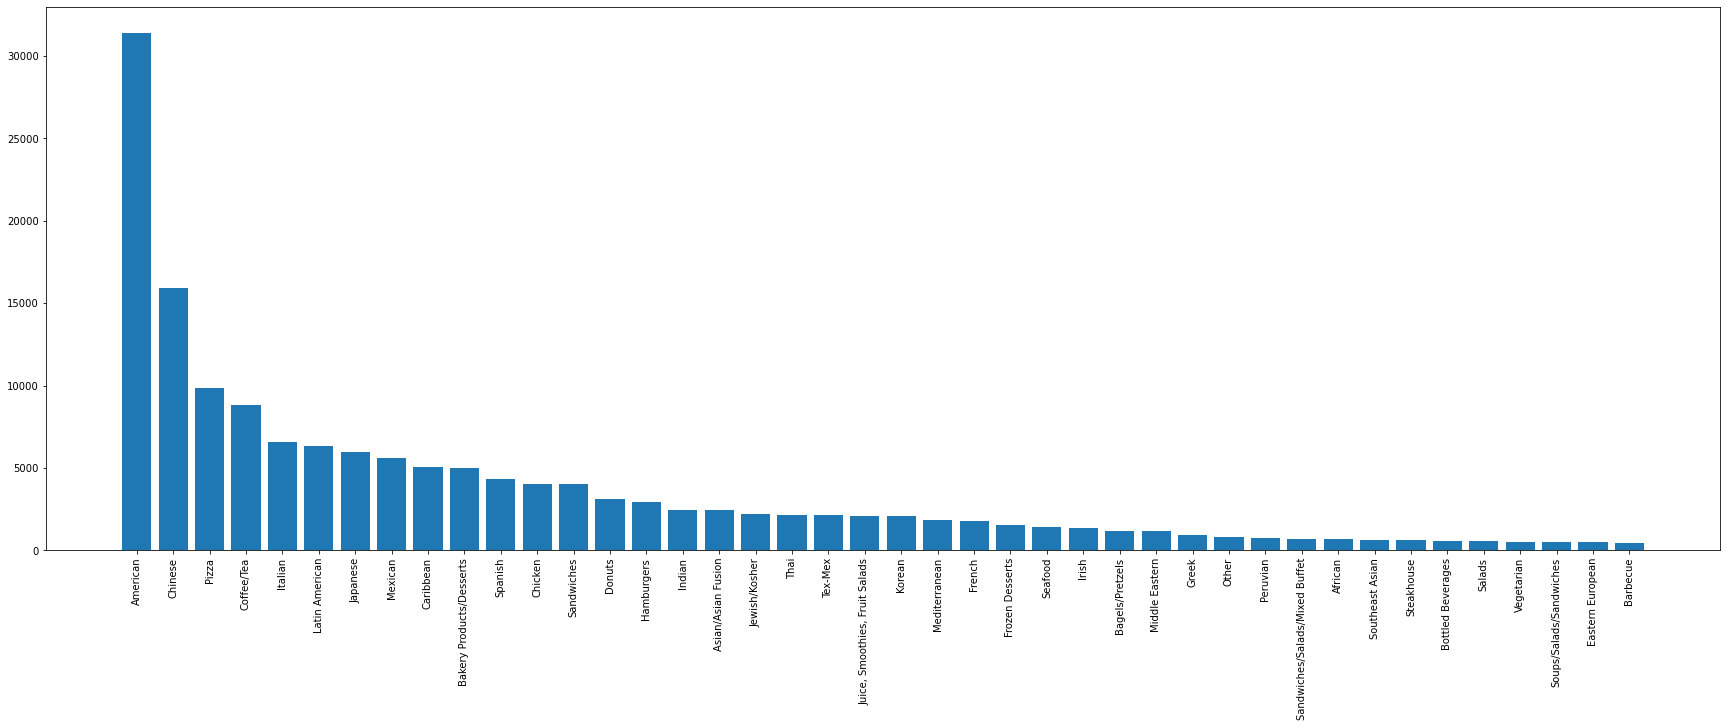

In [8]:
cuisines = pd.DataFrame(df["CUISINE DESCRIPTION"].value_counts())

# First 43 cuisines
figure = plt.figure(figsize=(30,10))
plt.bar(cuisines.index[0:42], height=cuisines["CUISINE DESCRIPTION"][0:42])
plt.xticks(rotation=90)
plt.show()

# # Remaining cuisines
# figure = plt.figure(figsize=(30,10))
# plt.bar(cuisines.index[43:], height=cuisines["CUISINE DESCRIPTION"][43:])
# plt.xticks(rotation=90)
# plt.ylim(0, 30000)
# plt.show()

In [9]:
# A_grade_inspections = df[df["GRADE"] == "A"].sample(200)
A_grade_inspections = df.sample(200)


inspection_station_locations = A_grade_inspections[["Latitude", "Longitude"]].sample(1)
map = folium.Map(location=[inspection_station_locations.Latitude.mean(), 
                           inspection_station_locations.Longitude.mean()], 
                           zoom_start=11, 
                           control_scale=True)

plugins.HeatMap(list(zip(A_grade_inspections["Latitude"], A_grade_inspections["Longitude"])), radius=15, min_opacity=1).add_to(map)
map



To validate this map visually, lets look at a distribution of scores, by Bourough 

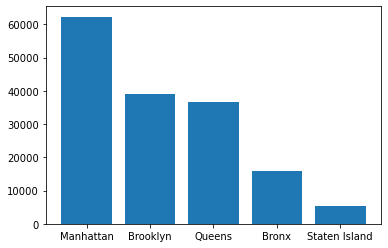

In [10]:
boros = pd.DataFrame(df["BORO"].value_counts())
plt.bar(boros.index, height=boros["BORO"])
plt.show()


Now, onto encoding...
Each violation string result should be classified into categories. We can use the violation codes to do this.

In [11]:
violations = df["VIOLATION CODE"]
violations = np.sort(violations.unique())
print(violations)

# 02A, 02B, 02C, 02H, 02G, 02I -> Food Not Cooled Properly

# 03A, -> Food Source Issue
# 04 -> Food Worker/Employee Issue
# 05 -> Food Surface Issue
# 06 -> 




['02A' '02B' '02C' '02D' '02E' '02F' '02G' '02H' '02I' '03A' '03B' '03C'
 '03D' '03E' '03G' '04A' '04B' '04C' '04D' '04E' '04F' '04G' '04H' '04I'
 '04J' '04K' '04L' '04M' '04N' '04O' '05A' '05B' '05C' '05D' '05E' '05F'
 '05H' '06A' '06B' '06C' '06D' '06E' '06F' '06G' '06H' '06I' '07A' '08A'
 '08B' '08C' '09A' '09B' '09C' '10A' '10B' '10C' '10D' '10E' '10F' '10G'
 '10H' '10I' '10J' '19A1' '19A3' '22F' '22G']


It would be interesting to see if any single violationc code is most common amoungst cases with lowest inspection grades...

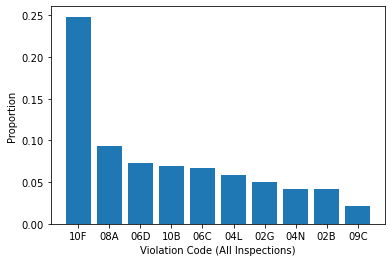

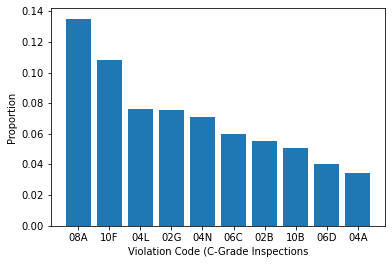

In [12]:
total_violations = pd.DataFrame(df["VIOLATION CODE"].value_counts())
total_violations["prop"] = total_violations["VIOLATION CODE"] / df.shape[0]

total_violations = total_violations[0:10]
plt.bar(total_violations.index, height=total_violations["prop"])
plt.xlabel("Violation Code (All Inspections)")
plt.ylabel("Proportion")
plt.show()

c_grade_violations_full = df[df["GRADE"] == "C"]
c_grade_violations = pd.DataFrame(c_grade_violations_full["VIOLATION CODE"].value_counts())
c_grade_violations["prop"] = c_grade_violations["VIOLATION CODE"] / c_grade_violations_full.shape[0]

c_grade_violations = c_grade_violations[0:10]
plt.bar(c_grade_violations.index, height=c_grade_violations["prop"])
plt.xlabel("Violation Code (C-Grade Inspections")
plt.ylabel("Proportion")
plt.show()

In [15]:
# Convert A, B, C to 3, 2, 1 for encodings, drop all other ratings

grades = ["A", "B", "C"]

df = df[~df['GRADE'].isin(grades)]

df.loc[df["GRADE"] == "A", "GRADE"] = 3
df.loc[df["GRADE"] == "B", "GRADE"] = 2
df.loc[df["GRADE"] == "C", "GRADE"] = 1
df = df[df['GRADE'].isin(grades)]


array([2, 3, 'P', 1, 'Z', 'N', 'G'], dtype=object)